# Tutorial 3: Convolutional Neural Networks

In this tutorial we will:


1.   Revise how tensors work and how images are represented as tensors
2.   Load and visualize a dataset
3.   Build and train a simple MLP classifier
4.   Standardize the data distribution and achieve better accuracy
5.   Understand how convolutional works on images
6.   Build and train a simple CNN classifier






General tips for PyTorch:

The documentation is very well written and is your best friend. Get familiar with it and use it often. https://pytorch.org/docs/stable/index.html

PyTorch has a big userbase, if you ever encounter an error, be sure someone else has encountered it before. Don't be afraid to Google it to find the answer.

## 1. Images as torch tensors

Let's have a look at how images are represented as tensors

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torchsummary import summary

import numpy as np
import time

In [3]:
# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


If the device is cpu, go to Runtime -> Change runtime type -> T4 GPU -> Save

### What's special about torch tensors?

1.   Torch tensors can be used on GPUs which are much faster than CPUs at large parallel computations
2.   Torch automatically keeps track of the gradient information

In [4]:
# CPU vs GPU

dim=6000

x=torch.randn(dim,dim)
y=torch.randn(dim,dim)
start_time = time.time()
z=torch.matmul(x,y)
elapsed_time = time.time() - start_time
print('CPU_time = ', elapsed_time)


x=torch.randn(dim,dim,device=device)
y=torch.randn(dim,dim,device=device)
start_time = time.time()
z=torch.matmul(x,y)
elapsed_time = time.time() - start_time
print('GPU_time = ',elapsed_time)

CPU_time =  0.8956553936004639
GPU_time =  0.019243240356445312


In [5]:
# Torch tensors automatically keep track of the gradient information
x=torch.rand(64, requires_grad=True)

f1=4*x
f2=6*x

function=(f1+f2).sum()

function.backward()
print(x.grad)

x = x.detach()
print(x.grad)

tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10.])
None


Let's see how we can load images with to numpy arrays

(256, 256, 3)


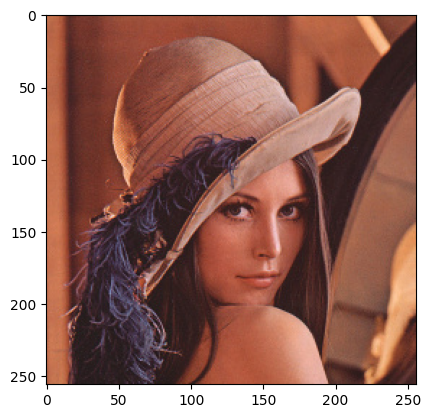

In [6]:
import matplotlib.pyplot as plt
import requests
import cv2
from PIL import Image
from io import BytesIO

# Display the image from a URL
url = "https://www.jpchacha.com/blog/content/00000002/lena_256.jpg"
response = requests.get(url, allow_redirects=True)
img = Image.open(BytesIO(response.content))
img_array = np.array(img)

plt.imshow(img_array)
print(img_array.shape)

In [7]:
print(img_array)

[[[195 111  75]
  [198 114  77]
  [195 111  74]
  ...
  [144  78  54]
  [150  80  55]
  [149  74  51]]

 [[196 112  76]
  [198 114  78]
  [193 109  72]
  ...
  [142  78  53]
  [148  82  56]
  [150  79  57]]

 [[197 115  78]
  [198 116  79]
  [194 112  75]
  ...
  [142  78  53]
  [148  82  58]
  [144  78  54]]

 ...

 [[169  88  61]
  [181 100  71]
  [190 107  75]
  ...
  [ 63  37  36]
  [ 69  41  40]
  [ 70  39  37]]

 [[168  87  60]
  [179  98  69]
  [188 107  77]
  ...
  [ 65  39  38]
  [ 69  39  39]
  [ 69  38  36]]

 [[165  85  58]
  [175  96  66]
  [187 108  77]
  ...
  [ 66  38  37]
  [ 67  37  35]
  [ 73  42  40]]]


By default, numpy loads images with the "height, width, channels" dimension format. When processing images with torch, it expects them to have the following shape:

[B, C, H, W]

Where:

*  B -> Dimension of the batch size
*  C -> Number of channels for each image (RGB images have 3, black and white images 1)
*  H -> Height of each image in the batch
*  W -> Width of each image in the batch

Let's reshape the image accordingly.

In [8]:
img_tensor = torch.from_numpy(img_array)
img_tensor = torch.transpose(img_tensor, 0, 2).unsqueeze(0)

print(img_tensor)
print(img_tensor.shape)

tensor([[[[195, 196, 197,  ..., 169, 168, 165],
          [198, 198, 198,  ..., 181, 179, 175],
          [195, 193, 194,  ..., 190, 188, 187],
          ...,
          [144, 142, 142,  ...,  63,  65,  66],
          [150, 148, 148,  ...,  69,  69,  67],
          [149, 150, 144,  ...,  70,  69,  73]],

         [[111, 112, 115,  ...,  88,  87,  85],
          [114, 114, 116,  ..., 100,  98,  96],
          [111, 109, 112,  ..., 107, 107, 108],
          ...,
          [ 78,  78,  78,  ...,  37,  39,  38],
          [ 80,  82,  82,  ...,  41,  39,  37],
          [ 74,  79,  78,  ...,  39,  38,  42]],

         [[ 75,  76,  78,  ...,  61,  60,  58],
          [ 77,  78,  79,  ...,  71,  69,  66],
          [ 74,  72,  75,  ...,  75,  77,  77],
          ...,
          [ 54,  53,  53,  ...,  36,  38,  37],
          [ 55,  56,  58,  ...,  40,  39,  35],
          [ 51,  57,  54,  ...,  37,  36,  40]]]], dtype=torch.uint8)
torch.Size([1, 3, 256, 256])


The value of the pixels are in Unsigned Integer 8 format, having values ranging from 0 to 255. When we process the images however, we will want to have floats in in an easier to operate range for neural networks.

The batch size here is 1 because we only have 1 image in this tensor.

The height and width are 256. In case of storing multiple images in the same tensor, they must all have the same shapes. If they don't we can apply some [padding](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html)

## 2. Load and create a dataset with Torch

Torch has some utilities that allow us to load and create datasets very easily. Let's load the Fashion MNIST dataset

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [10]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [11]:
batch_size = 64

# Get length of training and test dataset
print(f"The training data has: {len(training_data)} samples")
print(f"The test data has: {len(test_data)} samples")

# Let's investigate what a data entry is like
print(f"Each data sample is a {type(training_data[0])} of length {len(training_data[0])}")
print(f"The first entry is a {type(training_data[0][0])} of shape {training_data[0][0].shape}")
print(f"The second entry is the label: {training_data[0][1]}\n")

The training data has: 60000 samples
The test data has: 10000 samples
Each data sample is a <class 'tuple'> of length 2
The first entry is a <class 'torch.Tensor'> of shape torch.Size([1, 28, 28])
The second entry is the label: 9



Now that we have downloaded the data, let's move it into pytorch dataloaders

In [12]:
# Let's load the dataset into PyTorch dataloaders
train_dataloader = DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
)
test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size
)

for X, y in test_dataloader:
    print(f"Shape of X [B, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [B, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### Dataset visualization

Visualize the classes of the dataset

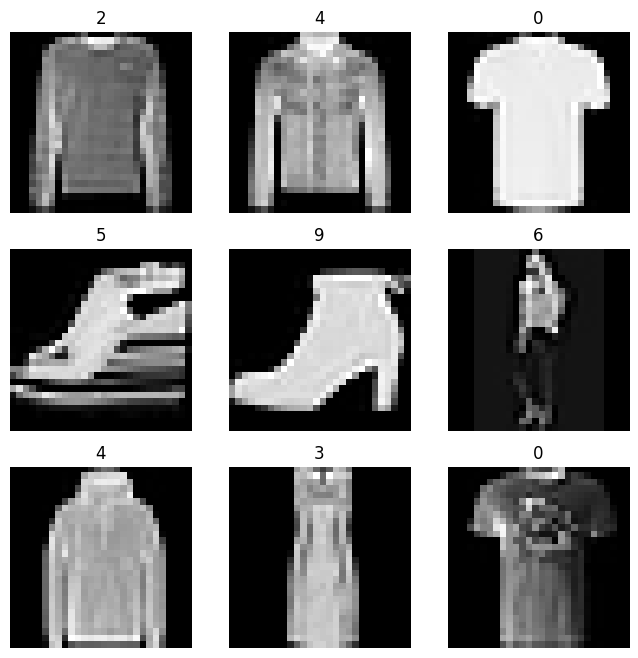

In [13]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

## 3. Build a simple MLP classifier

Before moving to CNNs, let's create a simple MLP classifier. To work with images. In order for the MLP to process an image, you will have to flatten the input image to a single dimension. Have a look on pytorch documentation for nn.Flatten

In [14]:
# Define model
class MLP(nn.Module):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(784, 1000),
            nn.LeakyReLU(),
            nn.Linear(1000, 500),
            nn.LeakyReLU(),
            nn.Linear(500,10),
            nn.Softmax()
        ])

    def forward(self, X):
        X = torch.flatten(X, start_dim= 1)
        for mod in self.layers:
            X = mod(X)
        # X = self.layers(X)
        return X
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

model = MLP().to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(count_parameters(model))

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=1000, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=500, out_features=10, bias=True)
    (5): Softmax(dim=None)
  )
)
1290510


In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Let's define a train and test function

In [30]:
def train(dataloader, model, loss_fn, optimizer):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
        model.cuda()
        model.train()

        losses = []
        for (X, y) in dataloader:
                X = X.cuda()
                y = y.cuda()
                
                optimizer.zero_grad()
                output = model(X)

                # Compute the loss between the predicted output and the actual labels y
                train_loss = loss_fn(output, y)

                # Calculate the gradients of the loss with respect to the model's parameters
                train_loss.backward()

                # Update the model's parameters based on the gradients
                optimizer.step()

                losses.append(train_loss)
        
        return train_loss.cpu()

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [31]:
def test(dataloader, model, loss_fn):
        
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
        model.cuda()
        model.eval()

        losses = []
        for (X, y) in dataloader:
                X=X.cuda()
                y=y.cuda()
                
                output = model(X)

                loss = loss_fn(output, y)

                losses.append(loss)

        return loss.cpu()
                

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################


Epoch 1
-------------------------------


/home/ninnin/Documents/code/DeepRepr/venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Done!


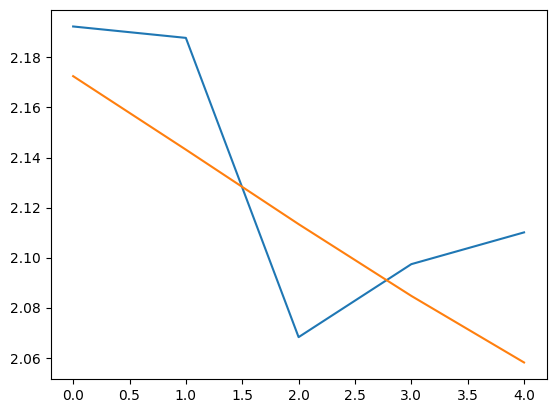

In [32]:
epochs = 5
train_losses = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss = test(test_dataloader, model, loss_fn)

    train_losses.append(train_loss.detach())
    test_losses.append(val_loss.detach())
print("Done!")

plt.plot(train_losses)
plt.plot(test_losses)

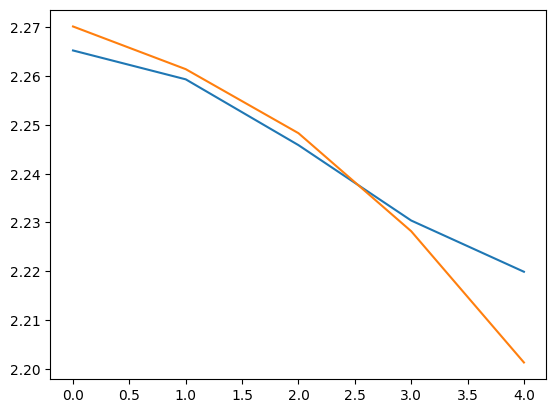

## 4. Can we get better performance?

Hopefully got got accuracy better than random (10%), if not, something is wrong with your code. But can we get better performance than this?
Let's try to standardize the data. We can do this by subtracting the mean and dividing by the standard deviation

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

train_dataloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
)

mean = 0.
std = 0.

# Calculate the mean and standard deviation of the training data
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################



        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [ ]:
# Now normalize the data. Have a look at transforms.Compose to concatenate multiple sequential data transformations
# transforms.Normalize is what you want to use here

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################


# data_transforms = your code here

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transforms,
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transforms,
)

train_dataloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True
)

mean = 0.
std = 0.
for images, _ in train_dataloader:
    batch_samples = images.size(0)
    images = images.view(batch_size, -1)
    mean += images.mean(1).sum()
    std += images.std(1).sum()

mean /= len(train_dataloader.dataset)
std /= len(train_dataloader.dataset)


print(mean, std)

In [ ]:
# Let's train again
model = MLP().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

### Deep learning models are only as good as the data they are trained on
With simple data normalization we managed to increase performance significantly

## 5. How does convolution work on images?

In the ancient days of classical computer vision, convolution was used to extract edges and features from images. This was done with predefined filters, such as Sobel or Laplacian operators, to detect edges, corners, and other basic visual features. The resulting images were then processed further through techniques like thresholding, feature matching, and clustering. These handcrafted features were critical for tasks like object detection and recognition, but they lacked the adaptability and performance of modern deep learning approaches.

Let's see how an edge detector like the sobel filter worked in practice. If you want to know more, have a look [here](http://www.theobjects.com/dragonfly/dfhelp/2021-1/Content/Viewing%20and%20Processing%20Images/Image%20Filtering/Edge%20Detection%20Filters.htm).

In [ ]:
# Display the image from a URL
import requests
from PIL import Image
from io import BytesIO

url = "https://i.sstatic.net/MCZ7o.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

img_array = np.array(img)
plt.imshow(img_array)

# Permute is similar to transpose but allows us to reorder multiple dimensions
# Unsqueeze is creating a new dimension in the position we ask it to (in this case in the batch_size position)
img_tensor = torch.from_numpy(img_array).permute(2,0,1).unsqueeze(0)
print(img_tensor.shape)

In [ ]:
# The image is black and white. We only need a single channel, and we need to transform its pixels in the range [0,1] float

img_tensor = torch.mean(img_tensor.float() / 255.0, dim=1, keepdim=True)
print(img_tensor)
print(img_tensor.shape)

In [ ]:
# Define Sobel kernels
sobel_x = torch.tensor([[[[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]]]], dtype=torch.float32)

sobel_y = torch.tensor([[[[-1, -2, -1],
                          [0,  0,  0],
                          [1,  2,  1]]]], dtype=torch.float32)

# Apply Sobel filter in x direction
grad_x = F.conv2d(img_tensor, sobel_x, padding=1)

# Apply Sobel filter in y direction
grad_y = F.conv2d(img_tensor, sobel_y, padding=1)

# Compute magnitude
grad_magnitude = torch.sqrt(grad_x ** 2 + grad_y ** 2)

grad_x_np = grad_x.squeeze().detach().numpy()
grad_y_np = grad_y.squeeze().detach().numpy()
grad_magnitude_np = grad_magnitude.squeeze().detach().numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Sobel X")
plt.imshow(grad_x_np, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Sobel Y")
plt.imshow(grad_y_np, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Gradient Magnitude")
plt.imshow(grad_magnitude_np, cmap='gray')

plt.show()

## 6. Convolutional Neural Networks

Instead of using pre-defined filters, convolutional neural networks (CNNs) learn their own filters directly from data during training. These learned filters automatically adapt to capture relevant features like edges, textures, and complex patterns, enabling more accurate and scalable feature extraction compared to classical methods.

CNNs are the predominant neural networks used in computer vision*

Their main building blocks are convolutions, used for processing information and deriving more complex features, and pooling layers for aggregating and downsampling information.

We will now modify the MLP network we used in tutorial 3, and make a very simple CNN.

*Vision Transformers (ViT) now outperform CNNs on tasks with large data availability (ImageNet for example). We will talk about transformers in a future lecture.

## Build a simple CNN
Let's now build a simple Convolutional Neural Network (CNN) for the same task. The main building blocks of CNNs are convolutions and pooling layers. Have a look at the PyTorch documentation to see how they are defined and what parameters they take as input.

[Convolution](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#conv2d)

[Avg Pooling layer](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html)


### Build a CNN with the following layers:
* Convolution(in_channel, out_channel, kernel_size, stride, padding)
* Relu
* Average pooling layer
* Convolution(in_channel, out_channel, kernel_size, stride, padding)
* Relu
* Flatten
* Linear(flattened_dimension, 10)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################



        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

model = SimpleCNN().to(device)

summary(model, (1,28,28))

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

# Build an improved CNN

Feel free to experiment with the following blocks:

###Convolutions
* [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

###Pooling blocks
* [AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html#avgpool2d)
* [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#maxpool2d)

###Activation functions
* [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#relu)
* [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#leakyrelu)
* [GELU](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html#gelu)

###Dropout
* [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#dropout)
* [Dropout2d](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html#dropout2d)

###Normalization layers
* [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#batchnorm2d)
* [LayerNorm](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#layernorm)

# Challenge
 Improve performance as much as you can. Can you get close to ~90% accuracy? Only change the CNN, do **not** change optimizers, data transformations or number of epochs. Feel free to change as many layers as you want, make the network wider, deeper whatever you like. Try to keep your network relatively small - don't make it larger than the original MLP (670K params)


Again, PyTorch documentation is your best friend
https://pytorch.org/docs/stable/index.html


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        ########################################################################
        #                            IMPROVE CODE HERE                         #
        ########################################################################



        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

model = CNN().to(device)

summary(model, (1,28,28))

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

# More advanced CNNs

There exists many different types of CNN models, one of the most common backbones used is the ResNet. Have a look at how more advanced neural networks are built. You can find more here:

https://github.com/kuangliu/pytorch-cifar

In [ ]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())



model = ResNet18().to(device)

summary(model, (3,32,32))

# Optional

1.   If you want to learn more about how CNNs work, try visualizing how their feature extraction pipeline works. Refer to: https://arxiv.org/abs/1311.2901
2.   Beyond image classification, there are many other tasks that CNNs are used for, such as image segmentation, object detection, super resolution and more. Have a look at the U-Net for image segmentation [[1]](https://github.com/milesial/Pytorch-UNet) [[2]](https://arxiv.org/abs/1505.04597)